# Visualizing Asset Price Correlations

Ricardo Basso Garcia, rbgarcia@gmail.com

Based on the tutorial: https://engineeringfordatascience.com/posts/visualising_asset_price_correlations/

Using the dataset 'desafio.csv', chalange posted by Femisapien at  https://twitter.com/Hypatia435/status/1511366255537803264?s=20&t=uR8dPCNUiRshXKzwqOATHQ

## Introduction

Portfolio risk can be mitigated by diversification, which may be achieved by investing in assets that are uncorrelated or negatively correlated. Thus, it is necessary to analyze the assets' returns during a period of time for extracting correlations between different assets and/or classes of assets.

There are at least three network methods to extract insightful information from a basic correlation matrix (Zhan et al., 2015): hierarchical cluster analysis, minimum spanning trees (MST), and neighbor-networks. In the this report, we depart from a basic correlation table and heatmap to gradually developing more refined analyses and plots of assets correlations.

**References consulted:**

Soramaki, K., Cook, S. R., & Laubsch, A. (2016). A network-based method for visual identification of systemic risks. Journal of Network Theory in Finance, 2(1), 67-101.

Zhan, H. C. J., Rea, W., & Rea, A. (2015). A Comparision of Three Network Portfolio Selection Methods--Evidence from the Dow Jones. arXiv preprint arXiv:1512.01905.


## Data preparation

### Library imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from IPython.core.display import display, HTML
from plotly.offline import init_notebook_mode
import networkx as nx

# plotly offline mode
init_notebook_mode(connected=True)

# Set renderer for jupyter notebook
import plotly.io as pio
pio.renderers.default = "notebook"

### Load data

In [2]:
# DF loading data from csv file 
df_prices = pd.read_csv('desafio.csv', index_col= 'Date')
df_prices.index = pd.to_datetime(df_prices.index)

# Display the first and last five rows
display(df_prices)

ABEV3   ALPA4   AMER3  ASAI3  AZUL4   B3SA3   BBAS3   BBDC3  \
Date                                                                       
2020-01-01  17.423  32.783  61.085    NaN  58.28  12.608  45.751  26.055   
2020-01-02  17.917  32.171  63.340    NaN  58.80  13.345  46.600  27.103   
2020-01-03  17.665  32.171  62.484    NaN  56.76  12.961  46.522  26.680   
2020-01-06  17.749  31.668  62.096    NaN  55.00  12.836  45.907  26.527   
2020-01-07  17.787  32.388  61.940    NaN  56.82  13.251  45.560  26.075   
...            ...     ...     ...    ...    ...     ...     ...     ...   
2022-03-25  14.320  26.150  32.280  15.84  24.74  15.140  35.300  18.383   
2022-03-28  14.740  26.050  31.960  16.24  24.69  15.090  34.960  18.303   
2022-03-29  15.250  26.860  34.650  16.22  25.38  15.540  35.110  18.532   
2022-03-30  15.170  26.310  34.550  16.17  24.30  15.670  34.900  18.452   
2022-03-31  15.400  26.070  32.650  16.29  23.92  15.710  34.700  18.253   

             BBDC4   BBSE3  ...       IOE1        DXY     OD1       VIX  \
Date                        ...                                           
2020-01-01  27.754  30.884  ...  401.14657  387.67997   4.403  55.38458   
2020-01-02  28.782  31.212  ...  408.58866  390.60901   4.412  50.29525   
2020-01-03  28.797  30.868  ...  412.52166  391.40955   4.404  56.66744   
2020-01-06  28.282  31.376  ...  412.57166  392.20395   4.405  56.19084   
2020-01-07  27.791  31.392  ...  420.83241  395.32448   4.402  56.19839   
...            ...     ...  ...        ...        ...     ...       ...   
2022-03-25  22.261  24.450  ...  640.65235  471.24329  11.650  99.26786   
2022-03-28  22.151  24.590  ...  682.34623  473.72434  11.650  93.84514   
2022-03-29  22.551  24.800  ...  682.49849  469.18048  11.650  90.11331   
2022-03-30  22.411  24.900  ...  649.61449  466.99596  11.648  92.30848   
2022-03-31  22.201  25.560  ...  705.60547  465.15340  11.650  97.27758   

                 BTC      VXEWZ        EEM  UST10Y          NDX          SPX  
Date                                                                          
2020-01-01   7216.21  110.20646  174.10554  1.9175  35099.96700  12985.15098  
2020-01-02   6960.58  102.40549  178.25972  1.8771  35784.32089  13139.88641  
2020-01-03   7269.82  106.38281  175.32300  1.7881  35544.08058  13074.94022  
2020-01-06   7575.93  113.03081  175.55147  1.8090  35899.31426  13170.48259  
2020-01-07   8021.36  112.27452  176.22095  1.8177  36051.93361  13192.47965  
...              ...        ...        ...     ...          ...          ...  
2022-03-25  44577.76  161.13736  214.89751  2.4731  70381.00956  21671.30481  
2022-03-28  47967.56  164.02582  216.08764  2.4585  71650.26318  21874.18846  
2022-03-29  47486.26  155.05211  219.18036  2.3944  72659.55383  22083.00564  
2022-03-30  47277.24  154.86622  218.90434  2.3488  71972.67987  21978.53973  
2022-03-31  45767.58  153.81781  213.62271  2.3380  70206.83159  21435.18187  

[587 rows x 107 columns]

### Data consistency verification

#### Missing data

In [3]:
# Display columns with missing data (sum NaN > 0)
df_prices.isna().sum()[df_prices.isna().sum() > 0]

ASAI3     303
CASH3     221
CMIN3     296
IGTI11    493
LWSA3      26
PETZ3     182
RDOR3     246
RRRP3     226
SOMA3     152
dtype: int64

**Note:** The missing data are mainly from stocks that have gone public in the past 2 years.

In [4]:
# Get recent IPOs tickers
recent_ipos = list(df_prices.isna().sum()[df_prices.isna().sum() > 0].index)

#### Duplicated data

In [5]:
# Sum of duplicated cases
n_duplicates = df_prices.duplicated().sum()

print(f'{n_duplicates} duplicated cases in {len(df_prices)} rows')

0 duplicated cases in 587 rows


#### Dataframe summary

In [6]:
# DF shape and covered timeperiod 
print(f'There are {df_prices.shape[0]} rows and {df_prices.shape[1]} columns in the dataset')
print(f'Data timeperiod covers: {min(df_prices.index).date()}'
      f' to {max(df_prices.index).date()}')

There are 587 rows and 107 columns in the dataset
Data timeperiod covers: 2020-01-01 to 2022-03-31


In [7]:
# Verifying the all columns have float numbers
print('Number of data types in the Dataframe:', df_prices.dtypes.nunique())
print('Data types in the Dataframe:', df_prices.dtypes.unique())

Number of data types in the Dataframe: 1
Data types in the Dataframe: [dtype('float64')]


### Conversion to log daily returns

In [8]:
# DF with the log daily returns
df_log_returns = np.log(df_prices).diff(1)

# Display first and last five rows
display(df_log_returns)

ABEV3     ALPA4     AMER3     ASAI3     AZUL4     B3SA3  \
Date                                                                     
2020-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-02  0.027959 -0.018845  0.036251       NaN  0.008883  0.056810   
2020-01-03 -0.014165  0.000000 -0.013607       NaN -0.035310 -0.029197   
2020-01-06  0.004744 -0.015759 -0.006229       NaN -0.031499 -0.009691   
2020-01-07  0.002139  0.022481 -0.002515       NaN  0.032555  0.031819   
...              ...       ...       ...       ...       ...       ...   
2022-03-25  0.008415  0.019696  0.060005  0.034032  0.065995  0.028881   
2022-03-28  0.028908 -0.003831 -0.009963  0.024939 -0.002023 -0.003308   
2022-03-29  0.034015  0.030620  0.080813 -0.001232  0.027563  0.029385   
2022-03-30 -0.005260 -0.020689 -0.002890 -0.003087 -0.043485  0.008331   
2022-03-31  0.015048 -0.009164 -0.056563  0.007394 -0.015761  0.002549   

               BBAS3     BBDC3     BBDC4     BBSE3  ...      IOE1       DXY  \
Date                                                ...                       
2020-01-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-01-02  0.018387  0.039435  0.036370  0.010564  ...  0.018382  0.007527   
2020-01-03 -0.001675 -0.015730  0.000521 -0.011083  ...  0.009580  0.002047   
2020-01-06 -0.013308 -0.005751 -0.018046  0.016323  ...  0.000121  0.002028   
2020-01-07 -0.007587 -0.017186 -0.017513  0.000510  ...  0.019825  0.007925   
...              ...       ...       ...       ...  ...       ...       ...   
2022-03-25 -0.000566  0.013142  0.009025  0.002047  ... -0.007635 -0.009057   
2022-03-28 -0.009678 -0.004361 -0.004954  0.005710  ...  0.063050  0.005251   
2022-03-29  0.004281  0.012434  0.017897  0.008504  ...  0.000223 -0.009638   
2022-03-30 -0.005999 -0.004326 -0.006228  0.004024  ... -0.049381 -0.004667   
2022-03-31 -0.005747 -0.010843 -0.009415  0.026161  ...  0.082677 -0.003953   

                 OD1       VIX       BTC     VXEWZ       EEM    UST10Y  \
Date                                                                     
2020-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-02  0.002042 -0.096391 -0.036067 -0.073415  0.023580 -0.021294   
2020-01-03 -0.001815  0.119289  0.043469  0.038104 -0.016612 -0.048574   
2020-01-06  0.000227 -0.008446  0.041245  0.060616  0.001302  0.011621   
2020-01-07 -0.000681  0.000134  0.057132 -0.006713  0.003806  0.004798   
...              ...       ...       ...       ...       ...       ...   
2022-03-25  0.000000 -0.049552  0.015420 -0.035063 -0.017016  0.041823   
2022-03-28  0.000000 -0.056176  0.073290  0.017767  0.005523 -0.005921   
2022-03-29  0.000000 -0.040578 -0.010085 -0.056263  0.014211 -0.026419   
2022-03-30 -0.000172  0.024068 -0.004411 -0.001200 -0.001260 -0.019228   
2022-03-31  0.000172  0.052433 -0.032453 -0.006793 -0.024423 -0.004609   

                 NDX       SPX  
Date                            
2020-01-01       NaN       NaN  
2020-01-02  0.019310  0.011846  
2020-01-03 -0.006736 -0.004955  
2020-01-06  0.009945  0.007281  
2020-01-07  0.004242  0.001669  
...              ...       ...  
2022-03-25 -0.009828 -0.004004  
2022-03-28  0.017873  0.009318  
2022-03-29  0.013988  0.009501  
2022-03-30 -0.009498 -0.004742  
2022-03-31 -0.024841 -0.025033  

[587 rows x 107 columns]

### Set period of analysis

Data exploration indicated robust correlation patterns considering the entire dataset period. Uncomment below for exploring other time windows.  

In [9]:
#days = 252
#df_log_returns = df_log_returns.iloc[-days:]
#df_log_returns.shape

## Exploratory data analysis

### Correlation matrix (coefficients)

In [10]:
# Correlation between assets returns
correlation_matrix = df_log_returns.corr()
display(correlation_matrix)

ABEV3     ALPA4     AMER3     ASAI3     AZUL4     B3SA3     BBAS3  \
ABEV3   1.000000  0.397797  0.337286  0.319979  0.528346  0.477588  0.557513   
ALPA4   0.397797  1.000000  0.407221  0.359603  0.571421  0.497394  0.440089   
AMER3   0.337286  0.407221  1.000000  0.256715  0.389427  0.489288  0.420004   
ASAI3   0.319979  0.359603  0.256715  1.000000  0.384458  0.391338  0.302073   
AZUL4   0.528346  0.571421  0.389427  0.384458  1.000000  0.569777  0.659738   
...          ...       ...       ...       ...       ...       ...       ...   
VXEWZ  -0.478208 -0.421667 -0.355583 -0.308003 -0.508581 -0.547429 -0.512526   
EEM     0.291454  0.272366  0.328549  0.075202  0.322134  0.309301  0.327142   
UST10Y  0.248990  0.124929  0.218732  0.057117  0.267070  0.284740  0.365922   
NDX     0.187700  0.194602  0.264504  0.091528  0.157481  0.232453  0.165246   
SPX     0.234119  0.185855  0.231812  0.039175  0.216085  0.239937  0.262814   

           BBDC3     BBDC4     BBSE3  ...      IOE1       DXY       OD1  \
ABEV3   0.589767  0.584322  0.489366  ... -0.080296 -0.326665  0.009656   
ALPA4   0.380068  0.378677  0.284554  ... -0.057503 -0.307065  0.044044   
AMER3   0.399887  0.362915  0.447228  ... -0.060167 -0.237444 -0.047890   
ASAI3   0.269076  0.249871  0.315726  ... -0.044198 -0.215514 -0.027676   
AZUL4   0.617390  0.616871  0.455680  ... -0.107963 -0.456936  0.008809   
...          ...       ...       ...  ...       ...       ...       ...   
VXEWZ  -0.508045 -0.484549 -0.445442  ...  0.085975  0.501997 -0.061065   
EEM     0.340686  0.337383  0.261906  ...  0.043366  0.216251 -0.046393   
UST10Y  0.400334  0.403629  0.344690  ...  0.002469 -0.077822  0.010174   
NDX     0.185213  0.179551  0.154402  ...  0.062038  0.359531 -0.083490   
SPX     0.284623  0.290951  0.198106  ...  0.068785  0.371163 -0.057581   

             VIX       BTC     VXEWZ       EEM    UST10Y       NDX       SPX  
ABEV3  -0.346903  0.210720 -0.478208  0.291454  0.248990  0.187700  0.234119  
ALPA4  -0.315965  0.198872 -0.421667  0.272366  0.124929  0.194602  0.185855  
AMER3  -0.299014  0.169844 -0.355583  0.328549  0.218732  0.264504  0.231812  
ASAI3  -0.255515  0.216633 -0.308003  0.075202  0.057117  0.091528  0.039175  
AZUL4  -0.401813  0.251410 -0.508581  0.322134  0.267070  0.157481  0.216085  
...          ...       ...       ...       ...       ...       ...       ...  
VXEWZ   0.626730 -0.251734  1.000000 -0.329334 -0.292599 -0.239277 -0.247282  
EEM    -0.460660  0.279264 -0.329334  1.000000  0.330429  0.797770  0.814143  
UST10Y -0.316496  0.164009 -0.292599  0.330429  1.000000  0.271731  0.378656  
NDX    -0.486327  0.274824 -0.239277  0.797770  0.271731  1.000000  0.935006  
SPX    -0.483277  0.256823 -0.247282  0.814143  0.378656  0.935006  1.000000  

[107 rows x 107 columns]

### Correlation matrix (p-values)

**Note:** At this point, I opted for the simple visualization of the correlation matrix with p-values. In cells 20 and 21, based on the unidimensional listing of the correlations between the selected assets, we display the significant and non-significant correlations in a more organized way. 

In [11]:
# Creating a function for generating DF with correlation p-values
from scipy.stats import pearsonr

def compute_corr_pvalues(df, dec=6, adj='n'):
    '''This function computes p-values of Pearson correlations to supplement pandas .corr() method.
    df:      DataFrame for computing correlation
    dec:     Number of p-value decimals, default = 6
    adj:     Correction of p-values 'y' or 'n', default = 'n'
    output:  Pandas DF with p-values 
    '''
    df = df.dropna() # drop NaN row
    # Create DF columns and rows 
    df_pvalues = pd.DataFrame(columns = df.columns) # Columns
    df_pvalues = df_pvalues.transpose().join(df_pvalues, how='outer') # Rows (index)
    
    # Compute p-values for each correlation
    for series_1 in df.columns: # get name of first series of data
        for series_2 in df.columns: # get name of second series of data
            df_pvalues[series_1][series_2] = round(pearsonr(df[series_1], df[series_2])[1], 6)

    # Compute correction if requested
    if adj == 'y':
        c_factor = df_pvalues.shape[0] - 1 # correction factor
        df_pvalues = np.minimum(1, df_pvalues * c_factor)
        return df_pvalues
    else:
        return df_pvalues

In [12]:
# Computing correlation p-values (uncorrected)
df_corr_pvalues = compute_corr_pvalues(df_log_returns)
df_corr_pvalues

ABEV3     ALPA4     AMER3     ASAI3     AZUL4     B3SA3     BBAS3  \
ABEV3        0.0       0.0   0.00012  0.000001       0.0  0.000002  0.000064   
ALPA4        0.0       0.0       0.0  0.000041       0.0       0.0  0.000859   
AMER3    0.00012       0.0       0.0  0.000383       0.0  0.000242  0.000546   
ASAI3   0.000001  0.000041  0.000383       0.0       0.0  0.000149  0.002592   
AZUL4        0.0       0.0       0.0       0.0       0.0  0.000001       0.0   
...          ...       ...       ...       ...       ...       ...       ...   
VXEWZ   0.000527  0.000017  0.001508  0.000002       0.0   0.00337   0.00013   
EEM      0.00176  0.031768  0.000355  0.114299  0.000002  0.292758  0.011126   
UST10Y  0.622736  0.421612  0.125829  0.281276  0.009521  0.801481  0.020621   
NDX     0.070914  0.100284  0.007885  0.085539  0.007894  0.680708  0.629945   
SPX     0.154945  0.437335  0.032656  0.225346  0.046981  0.993747  0.499442   

           BBDC3     BBDC4     BBSE3  ...      IOE1       DXY       OD1  \
ABEV3   0.010758  0.027228  0.001352  ...  0.764703  0.126985  0.090954   
ALPA4   0.179083  0.603539  0.021307  ...  0.518718  0.000058  0.087449   
AMER3   0.021202  0.087294  0.001781  ...   0.84357  0.003035  0.366408   
ASAI3   0.012241  0.014758  0.000639  ...  0.340631  0.021279  0.442886   
AZUL4   0.002832  0.003151  0.002033  ...  0.494946  0.000484  0.173282   
...          ...       ...       ...  ...       ...       ...       ...   
VXEWZ   0.003536  0.007171  0.030347  ...  0.010766       0.0  0.564908   
EEM       0.0554  0.080193  0.547928  ...  0.062176  0.485421  0.506324   
UST10Y  0.001546  0.000273  0.055582  ...  0.560678   0.58089  0.992756   
NDX     0.601255  0.806601  0.270632  ...  0.517575  0.004154  0.933603   
SPX     0.295664  0.409566  0.346067  ...  0.570465  0.000061  0.858619   

             VIX       BTC     VXEWZ       EEM    UST10Y       NDX       SPX  
ABEV3    0.04457  0.000813  0.000527   0.00176  0.622736  0.070914  0.154945  
ALPA4   0.001275  0.028857  0.000017  0.031768  0.421612  0.100284  0.437335  
AMER3   0.000048  0.003238  0.001508  0.000355  0.125829  0.007885  0.032656  
ASAI3   0.003486  0.001008  0.000002  0.114299  0.281276  0.085539  0.225346  
AZUL4        0.0  0.000605       0.0  0.000002  0.009521  0.007894  0.046981  
...          ...       ...       ...       ...       ...       ...       ...  
VXEWZ        0.0  0.000064       0.0  0.000028   0.01329  0.001644  0.006928  
EEM          0.0  0.000214  0.000028       0.0  0.007105       0.0       0.0  
UST10Y  0.000054  0.009684   0.01329  0.007105       0.0  0.007755  0.002412  
NDX          0.0  0.000007  0.001644       0.0  0.007755       0.0       0.0  
SPX          0.0  0.000697  0.006928       0.0  0.002412       0.0       0.0  

[107 rows x 107 columns]

In [13]:
# Computing correlation p-values (corrected)
df_corr_pvalues_corrected = compute_corr_pvalues(df_log_returns, adj='y')
df_corr_pvalues_corrected

ABEV3     ALPA4     AMER3     ASAI3     AZUL4     B3SA3     BBAS3  \
ABEV3        0.0       0.0   0.01272  0.000106       0.0  0.000212  0.006784   
ALPA4        0.0       0.0       0.0  0.004346       0.0       0.0  0.091054   
AMER3    0.01272       0.0       0.0  0.040598       0.0  0.025652  0.057876   
ASAI3   0.000106  0.004346  0.040598       0.0       0.0  0.015794  0.274752   
AZUL4        0.0       0.0       0.0       0.0       0.0  0.000106       0.0   
...          ...       ...       ...       ...       ...       ...       ...   
VXEWZ   0.055862  0.001802  0.159848  0.000212       0.0   0.35722   0.01378   
EEM      0.18656         1   0.03763         1  0.000212         1         1   
UST10Y         1         1         1         1         1         1         1   
NDX            1         1   0.83581         1  0.836764         1         1   
SPX            1         1         1         1         1         1         1   

           BBDC3     BBDC4     BBSE3  ... IOE1       DXY OD1       VIX  \
ABEV3          1         1  0.143312  ...    1         1   1         1   
ALPA4          1         1         1  ...    1  0.006148   1   0.13515   
AMER3          1         1  0.188786  ...    1   0.32171   1  0.005088   
ASAI3          1         1  0.067734  ...    1         1   1  0.369516   
AZUL4   0.300192  0.334006  0.215498  ...    1  0.051304   1       0.0   
...          ...       ...       ...  ...  ...       ...  ..       ...   
VXEWZ   0.374816  0.760126         1  ...    1       0.0   1       0.0   
EEM            1         1         1  ...    1         1   1       0.0   
UST10Y  0.163876  0.028938         1  ...    1         1   1  0.005724   
NDX            1         1         1  ...    1  0.440324   1       0.0   
SPX            1         1         1  ...    1  0.006466   1       0.0   

             BTC     VXEWZ       EEM    UST10Y       NDX       SPX  
ABEV3   0.086178  0.055862   0.18656         1         1         1  
ALPA4          1  0.001802         1         1         1         1  
AMER3   0.343228  0.159848   0.03763         1   0.83581         1  
ASAI3   0.106848  0.000212         1         1         1         1  
AZUL4    0.06413       0.0  0.000212         1  0.836764         1  
...          ...       ...       ...       ...       ...       ...  
VXEWZ   0.006784       0.0  0.002968         1  0.174264  0.734368  
EEM     0.022684  0.002968       0.0   0.75313       0.0       0.0  
UST10Y         1         1   0.75313       0.0   0.82203  0.255672  
NDX     0.000742  0.174264       0.0   0.82203       0.0       0.0  
SPX     0.073882  0.734368       0.0  0.255672       0.0       0.0  

[107 rows x 107 columns]

### Correlation matrix heatmap

This is the simple heatmap of the correlation matrix, so we can observe the visualization improvement given by the clustermap analysis. 

In [14]:
# Visualize a simple heatmap of the correlation matrix
plt.figure(figsize=(25,20))
sns.heatmap(correlation_matrix, cmap="RdYlGn");

### Correlation matrix clustermap

**Note:** Open figure in a new tab and maximize for visualizing the details.

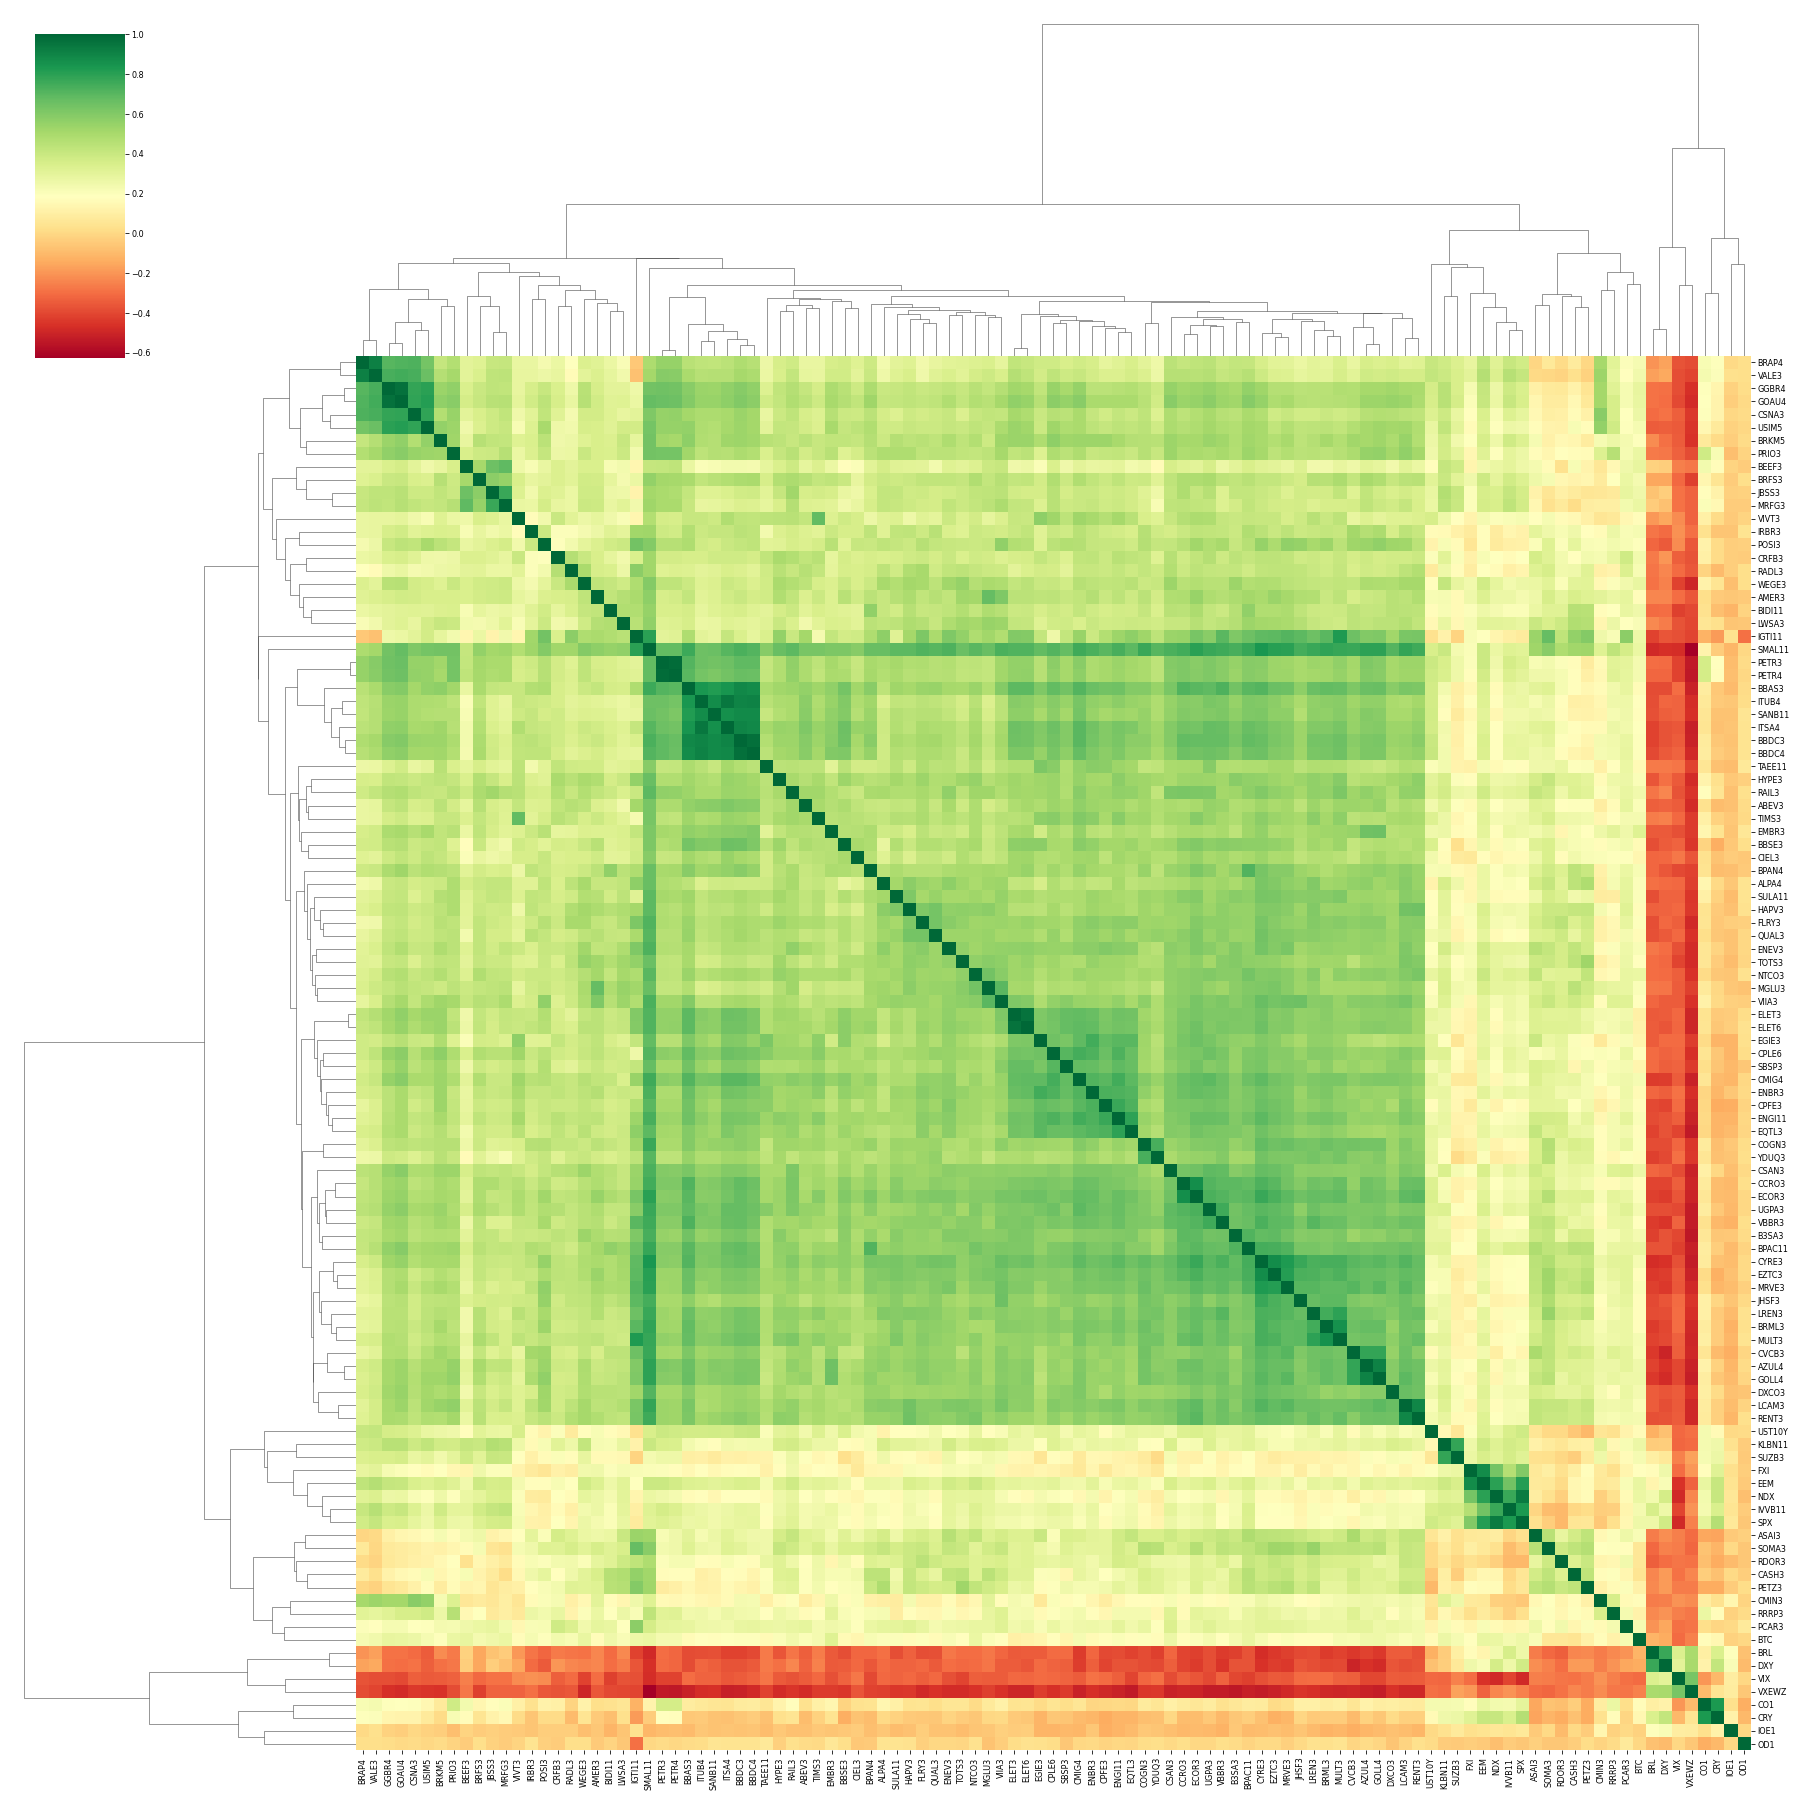

In [15]:
# visualise correlation matrix using a clustered heatmap
plt.rcParams.update({'font.size': 8}) # fontsize 10 for displaying all labels
sns.clustermap(correlation_matrix, cmap="RdYlGn",figsize=(25,25));

**Observations:** (from the bottom to the top)
1. The bottom cluster (with 8 tickers) is mainly negativelly correlated with most of the tickers (BRL, DXY, VIX, VXEWZ, CO1, CRY, IOE1, OD1)
 - The last 4 tickers (CO1, CRY, IOE1, OD1) have small/weak negative correlations with most of the tickers
 - The other tickers (BRL, DXY, VIX, VXEWZ) have strong negative correlations with most of the tickers
2. The next neighboring cluster is mainly weakly correlated with most of the assets, and it is mainly composed by recent IPOs (ASAI3, SOMA3, RDOR3, CASH3, PETZ3, CMIN3, RRRP3) plus PCAR3 and BTC.
 - PCAR3 may be consider as an atypical equity, as the recent IPOs.
 - **Note:** The other recent stocks (LWSA3 and IGTI11) are close together and on the borderline between asset clusters, also with an "atypical" correlation in comparison with the other equities.  
3. The next neighboring cluster is also mainly weakly correlated with most of the tickers, and it is  composed by UST10Y (US 10y treasury bonds), KLBN11 and SUZB3 (Brazilian cellulose stocks), FXI (China Large-caps ETF), EEM (Emerging markets ETF), IVVB11 (S&P 500 ETF), and NDX and SPX (indexes)
4. Then, we have a large cluster of moderate-to-strong positively correlated assets, all equities.

**Considerations:**
1. For futher analysing the correlations between assets, the exploratory data analysis provides support for the exclusion of the following tickers:
 - All of the recent IPOs and listings, including PCAR3
 - Non-asset tickers, such as the indexes NDX, SPX, VIX, VXEWZ, DXY
 - Tickers of equities with more liquid preferential stocks (e.g., BBDC3, ELET3, PETR3)
 - Exclusion of GOAU4 in favor of GGBR4 
 - Exclusion of BRAP4 (invests only in VALE3 stocks)
 - Exclusion of FXI in favor of EEM, as the Emerging Markets ETF is highly correlated with FXI, it is more diversified with less risk. 

### Data treatment (inclusion/exclusion)

List here the tickers to be excluded.<br>
**Note:** Here, I also opted for focusing the analysis on the equity space plus bonds, so I excluded some assets that the network analysis was keeping outside the main network of assets, such as IOE1, CO1, OD1, and CRY.

In [16]:
# List here the tickers to be excluded
del_tickers = recent_ipos.copy()
del_tickers.extend(['PCAR3','NDX','SPX','VIX','VXEWZ','DXY'])
del_tickers.extend(['BBDC3', 'BRAP4', 'ELET3', 'GOAU4', 'PETR3'])
del_tickers.extend(['BRL','BTC','CO1','IOE1', 'CRY', 'OD1', 'FXI'])

print(f'{len(del_tickers)} Tickers to delete:  ', end='')
for item in del_tickers:print(item,end=' ')

27 Tickers to delete:  ASAI3 CASH3 CMIN3 IGTI11 LWSA3 PETZ3 RDOR3 RRRP3 SOMA3 PCAR3 NDX SPX VIX VXEWZ DXY BBDC3 BRAP4 ELET3 GOAU4 PETR3 BRL BTC CO1 IOE1 CRY OD1 FXI 

In [17]:
# cleaning the correlation matrix
correlation_matrix = correlation_matrix.drop(del_tickers).drop(del_tickers,axis=1)

# Droping tickers from df_log_returns
df_log_returns.drop(del_tickers, axis=1, inplace=True)

# Updating p-values
df_corr_pvalues = compute_corr_pvalues(df_log_returns)
df_corr_pvalues_corrected = compute_corr_pvalues(df_log_returns, adj='y')

print(correlation_matrix.shape, df_corr_pvalues.shape, df_corr_pvalues_corrected.shape)

(80, 80) (80, 80) (80, 80)


## Data visualization

### Correlation matrix clustermap

Plot of the clustermap with the selected assets and using a cool-warm color code, so that weak correlations are blue and strong correlations are red.<br>
**Note:** Open figure in a new tab and maximize for visualizing the details

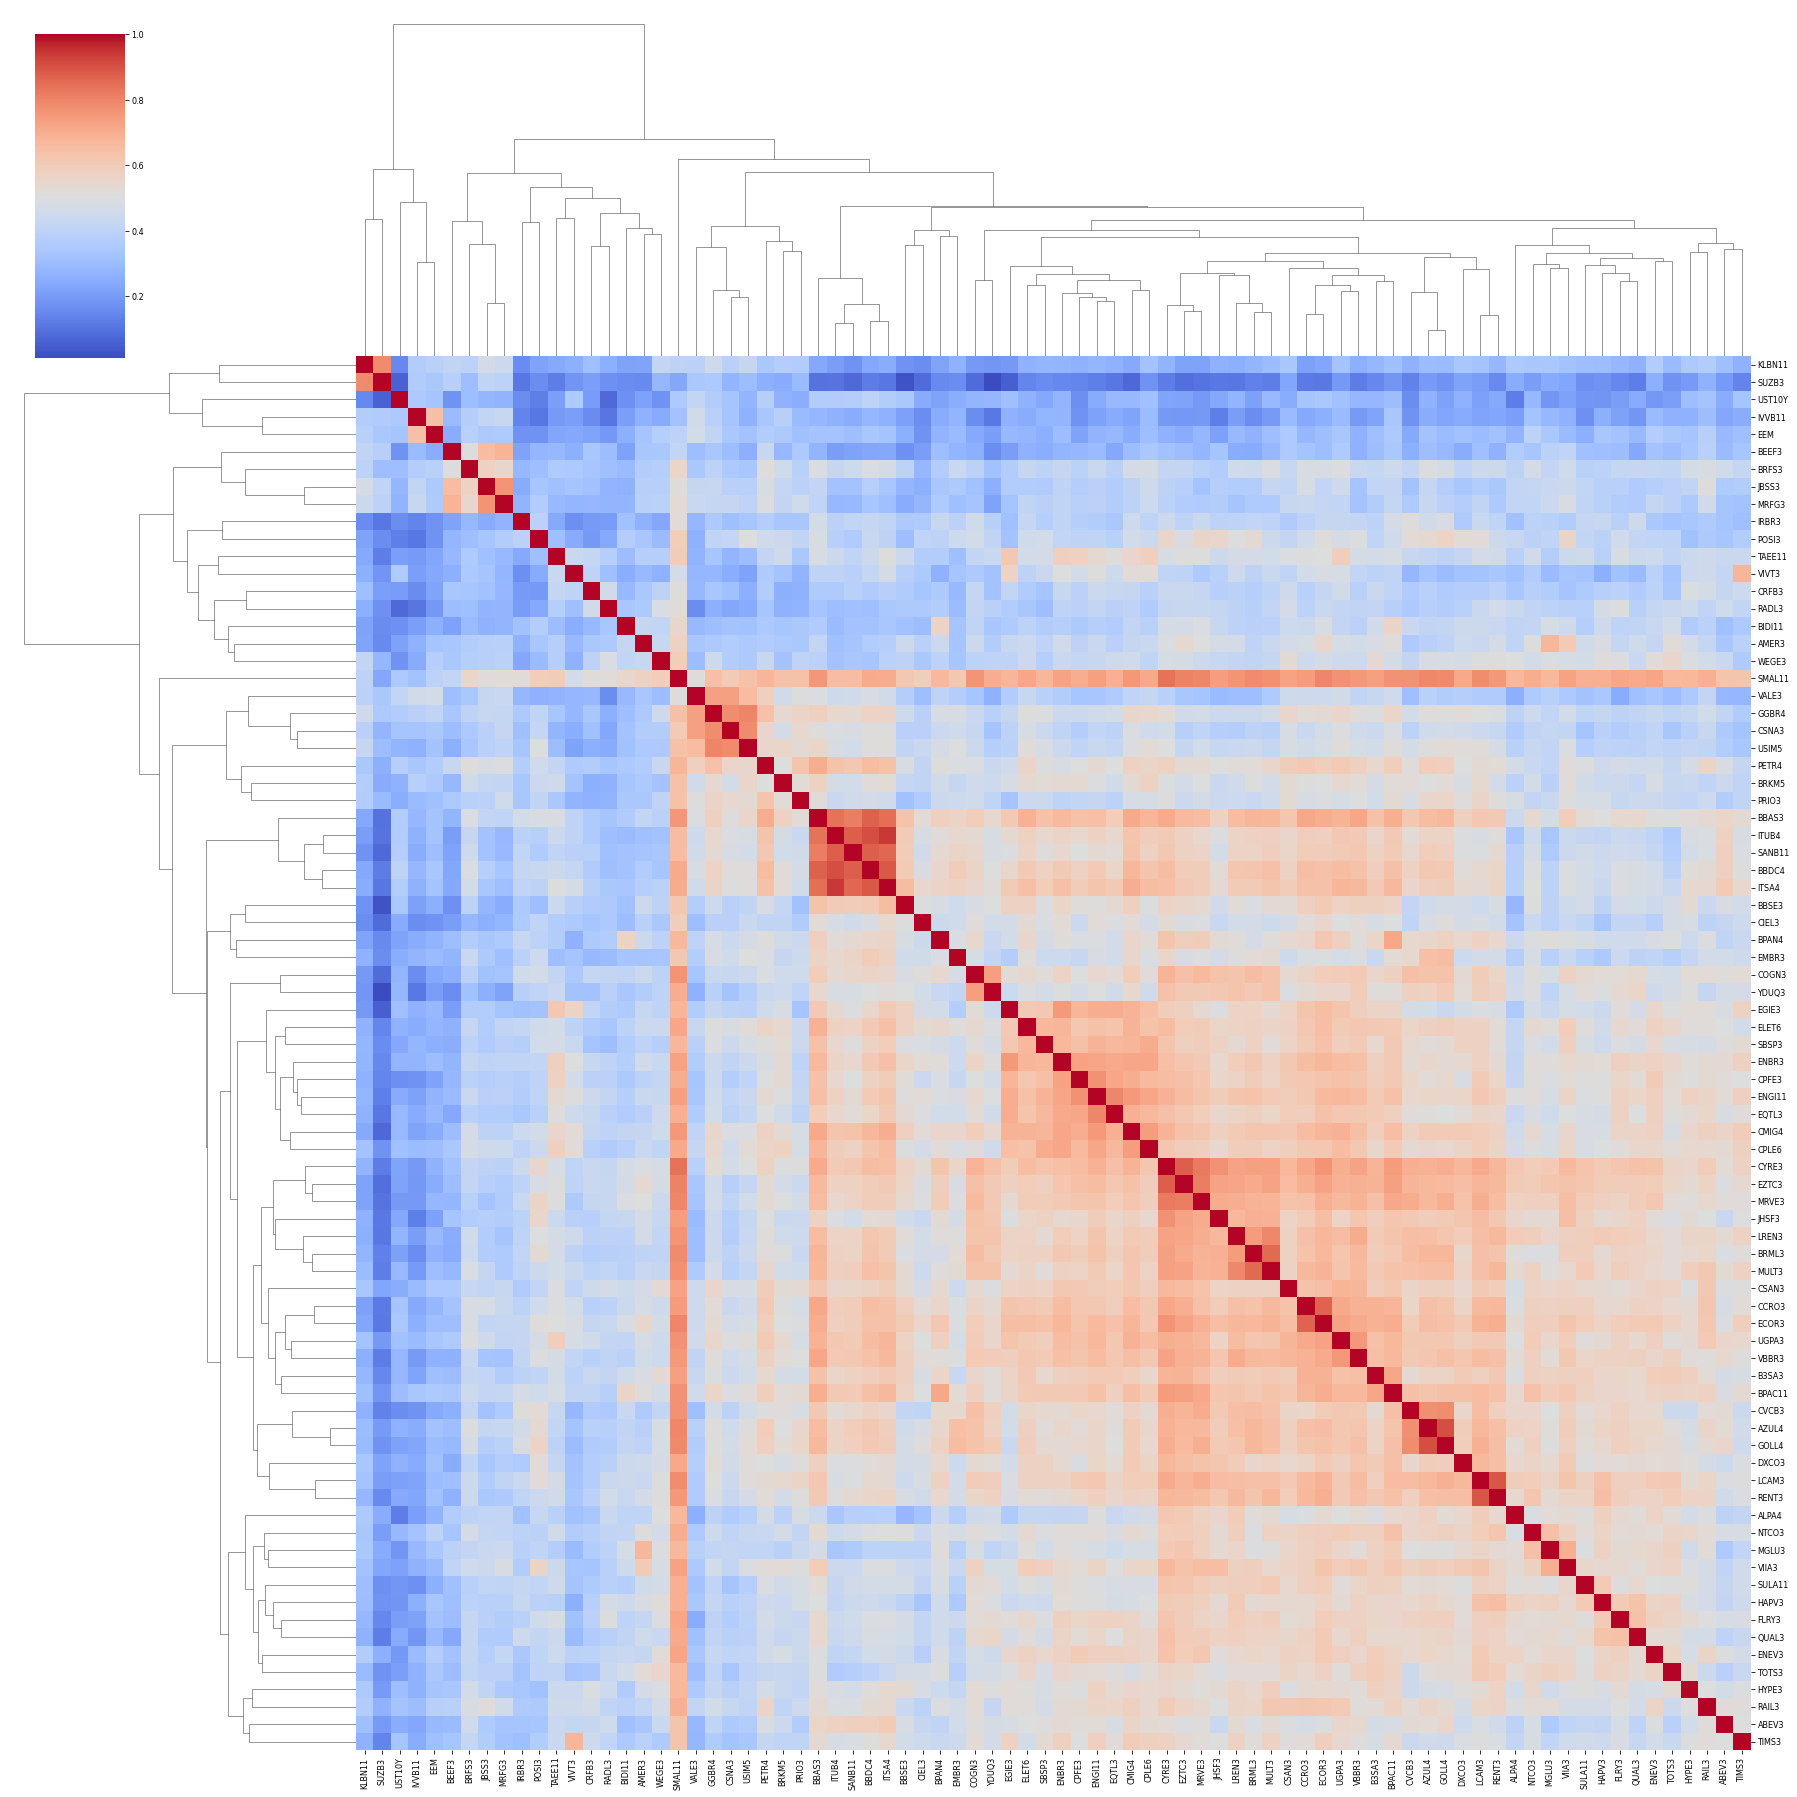

In [18]:
# visualise correlation matrix using a clustered heatmap
plt.rcParams.update({'font.size': 8}) # fontsize 10 for displaying all names
sns.clustermap(correlation_matrix, cmap="coolwarm",figsize=(25,25));

## Network Visualisations with NetworkX

### Create Network Data Structure

In [19]:
# convert matrix to list of edges and rename the columns
edges = correlation_matrix.stack().reset_index()
edges.columns = ["asset_1", "asset_2", "correlation"]

# add column with correlation p-values
# df_corr_pvalues.stack().reset_index()[0] for uncorrected p-values
edges['p_values'] = df_corr_pvalues_corrected.stack().reset_index()[0]

# remove self correlations
edges = edges.loc[edges["asset_1"] != edges["asset_2"]].copy()

# show the first and last 5 rows of the edge list dataframe
display(edges)

asset_1 asset_2  correlation  p_values
1      ABEV3   ALPA4     0.397797       0.0
2      ABEV3   AMER3     0.337286       0.0
3      ABEV3   AZUL4     0.528346       0.0
4      ABEV3   B3SA3     0.477588       0.0
5      ABEV3   BBAS3     0.557513       0.0
...      ...     ...          ...       ...
6394  UST10Y   WEGE3     0.173756  0.001817
6395  UST10Y   YDUQ3     0.284995       0.0
6396  UST10Y  IVVB11     0.350474       0.0
6397  UST10Y  SMAL11     0.347511       0.0
6398  UST10Y     EEM     0.330429       0.0

[6320 rows x 4 columns]

**Note:** Adjusted p-values are avaliable in case someone would like to filter the data according to significance criteria. 

### Filtering according to correlation strength or significance

In this report, at this point I opted for not excluding correlations according to coefficient values or significance values. Depending on the objetives, one may further analyze correlations according to their strength and/or significance. The codes are available below.

#### Useful filters

In [20]:
# Selecting assets that do not correlate significantly
edges[edges['p_values']>0.05].sort_values(by='correlation')

asset_1 asset_2  correlation  p_values
5195   SUZB3   YDUQ3     0.010882         1
6064   YDUQ3   SUZB3     0.010882         1
624    BBSE3   SUZB3     0.030054         1
5127   SUZB3   BBSE3     0.030054         1
5148   SUZB3   EGIE3     0.053765         1
...      ...     ...          ...       ...
5134   SUZB3   BRML3     0.134091  0.089981
1984   CVCB3   SUZB3     0.137658  0.065886
5144   SUZB3   CVCB3     0.137658  0.065886
3356   IRBR3  IVVB11     0.139015   0.05846
6121  IVVB11   IRBR3     0.139015   0.05846

[72 rows x 4 columns]

In [21]:
# Visualizing assets that correlate significantly
edges[edges['p_values']<0.05].sort_values(by='correlation')

asset_1 asset_2  correlation  p_values
5186   SUZB3   TIMS3     0.141865  0.045267
5344   TIMS3   SUZB3     0.141865  0.045267
5139   SUZB3   CPFE3     0.142990  0.040843
1584   CPFE3   SUZB3     0.142990  0.040843
2384   ELET6   SUZB3     0.143884  0.037604
...      ...     ...          ...       ...
523    BBDC4   ITUB4     0.907827       0.0
3043   GOLL4   AZUL4     0.910050       0.0
278    AZUL4   GOLL4     0.910050       0.0
3403   ITSA4   ITUB4     0.944109       0.0
3482   ITUB4   ITSA4     0.944109       0.0

[6248 rows x 4 columns]

**Note:** Correlation coefficients higher than 0.14 are significant. 

### Network information

In [22]:
# create undirected graph with weights corresponding to the correlation magnitude
G0 = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# print out the graph info
# check number of nodes and degrees are as expected
# (all should have degree = 38, i.e. average degree = 38)
print(nx.info(G0))

Graph with 80 nodes and 3160 edges


C:\Users\rblga\AppData\Local\Temp/ipykernel_3044/4113238830.py:7: DeprecationWarning:

info is deprecated and will be removed in version 3.0.




### Visualize the network

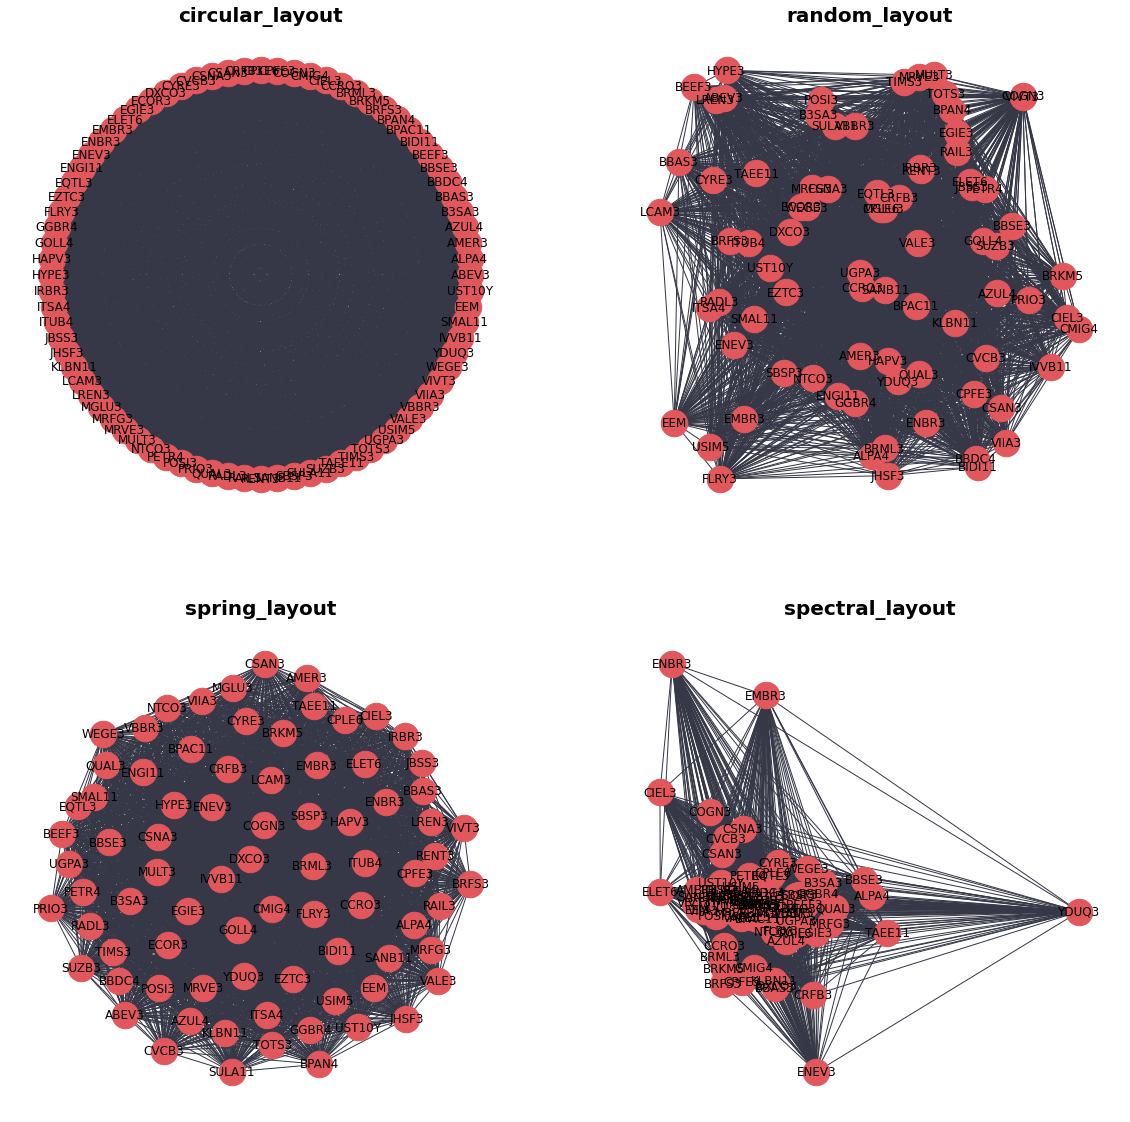

In [23]:
# create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# save different layout functions in a list
layouts = [nx.circular_layout, nx.random_layout, nx.spring_layout, nx.spectral_layout]

# plot each different layout
for layout, ax in zip(layouts, axs.ravel()):
    nx.draw(
        G0,
        with_labels=True,
        node_size=700,
        node_color="#e1575c",
        edge_color="#363847",
        pos=layout(G0),
        ax=ax,
    )
    ax.set_title(layout.__name__, fontsize=20, fontweight="bold")

### Improving the network visualization

#### Remove edges below a threshold

In [24]:
# 'winner takes all' method - set minimum correlation threshold to remove some
# edges from the diagram
threshold = 0.4 # a threshold of 0.5 was too severe

# create a new graph from edge list
Gx = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# list to store edges to remove
remove = []
# loop through edges in Gx and find correlations which are below the threshold
for asset_1, asset_2 in Gx.edges():
    corr = Gx[asset_1][asset_2]["correlation"]
    # add to remove node list if abs(corr) < threshold
    if abs(corr) < threshold:
        remove.append((asset_1, asset_2))

# remove edges contained in the remove list
Gx.remove_edges_from(remove)

print(str(len(remove)) + " edges removed")

925 edges removed


#### Create colour, edge thickness and node size features

In [25]:
# Function for assigning colors to correlations
def assign_colour(correlation):
    if correlation <= 0:
        return "#ffa09b"  # red
    else:
        return "#9eccb7"  # green

# Function for applying a scaling factor to thickness 
def assign_thickness(correlation, benchmark_thickness=2, scaling_factor=3):
    return benchmark_thickness * abs(correlation) ** scaling_factor


def assign_node_size(degree, scaling_factor=50):
    return degree * scaling_factor


# assign colours to edges depending on positive or negative correlation
# assign edge thickness depending on magnitude of correlation
edge_colours = []
edge_width = []
for key, value in nx.get_edge_attributes(Gx, "correlation").items():
    edge_colours.append(assign_colour(value))
    edge_width.append(assign_thickness(value))

# assign node size depending on number of connections (degree)
node_size = []
for key, value in dict(Gx.degree).items():
    node_size.append(assign_node_size(value))

#### Plot the improved visualization

In [26]:
# draw improved graph
sns.set(rc={"figure.figsize": (9, 9)})
font_dict = {"fontsize": 18}

nx.draw(
    Gx,
    pos=nx.circular_layout(Gx),
    with_labels=True,
    node_size=node_size,
    node_color="#e1575c",
    edge_color=edge_colours,
    width=edge_width,
)
plt.title("Asset price correlations", fontdict=font_dict);

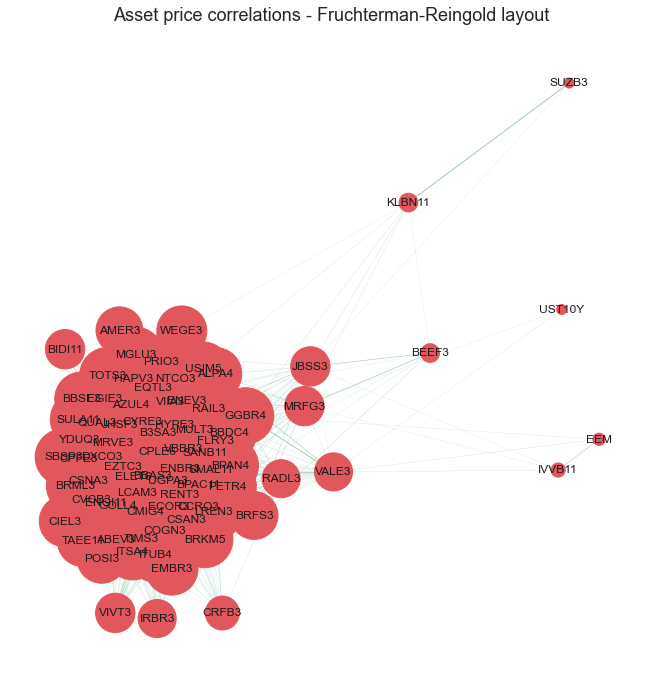

In [27]:
# draw improved graph
nx.draw(
    Gx,
    pos=nx.fruchterman_reingold_layout(Gx),
    with_labels=True,
    node_size=node_size,
    node_color="#e1575c",
    edge_color=edge_colours,
    width=edge_width,
)
plt.title("Asset price correlations - Fruchterman-Reingold layout", fontdict=font_dict);

#### Minimum spanning tree

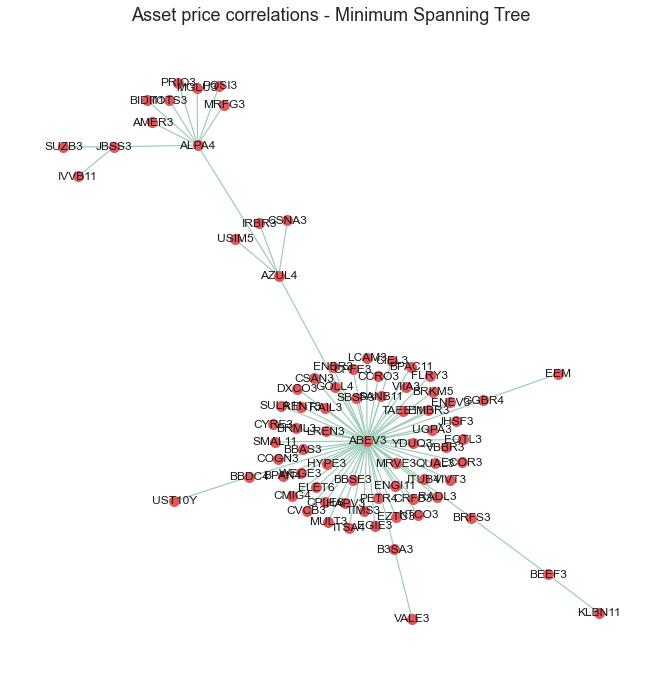

In [28]:
# create minimum spanning tree layout from Gx
# (after small correlations have been removed)
mst = nx.minimum_spanning_tree(Gx)

edge_colours = []

# assign edge colours
for key, value in nx.get_edge_attributes(mst, "correlation").items():
    edge_colours.append(assign_colour(value))


# draw minimum spanning tree. Set node size and width to constant
nx.draw(
    mst,
    with_labels=True,
    pos=nx.fruchterman_reingold_layout(mst),
    node_size=100,
    node_color="#e1575c",
    edge_color=edge_colours,
    width=1.2,
)

# set title
plt.title("Asset price correlations - Minimum Spanning Tree", fontdict=font_dict);

#### Useful functions

In [29]:
def convert_rankings_to_string(ranking):
    """
    Concatenate list of nodes and correlations into a single html
    string (required format for the plotly tooltip)

    Inserts html "<br>" inbetween each item in order to add a new
    line in the tooltip
    """
    s = ""
    for r in ranking:
        s += r + "<br>"
    return s


def calculate_stats(returns=df_log_returns):
    """Calculate annualised returns and volatility for all assets

    Returns:
        tuple: Outputs the annualised volatility and returns as a list of
            floats (for use in assigning node colours and sizes) and also
            as a lists of formatted strings to be used in the tool tips.
    """

    # log returns are additive, 252 trading days
    annualized_returns = list(returns.mean() * 252 * 100) # optmized calculation

    annualized_volatility = list(returns.std() * (252 ** 0.5) * 100) # optmized calculation

    # create string for tooltip
    annualized_returns_2dp = [
        "Annualized Returns: " "%.1f" % r + "%" for r in annualized_returns
    ]
    
    annualized_volatility_2dp = [
        "Annualized Volatility: " "%.1f" % r + "%" for r in annualized_volatility
    ]
    
    return (
        annualized_volatility,
        annualized_returns,
        annualized_volatility_2dp,
        annualized_returns_2dp,
    )

def get_top_and_bottom_three(df=correlation_matrix):
    """
    get a list of the top 3 and bottom 3 most/least correlated assests
    for each node.

    Args:
        df (pd.DataFrame): pandas correlation matrix

    Returns:
        top_3_list (list): list of lists containing the top 3 correlations
            (name and value)
        bottom_3_list (list): list of lists containing the bottom three
            correlations (name and value)
    """

    top_3_list = []
    bottom_3_list = []

    for col in df.columns:

        # exclude self correlation #reverse order of the list returned
        top_3 = list(np.argsort(abs(df[col]))[-4:-1][::-1])
        # bottom 3 list is returned in correct order
        bottom_3 = list(np.argsort(abs(df[col]))[:3])

        # get column index
        col_index = df.columns.get_loc(col)

        # find values based on index locations
        top_3_values = [df.index[x] + ": %.2f" % df.iloc[x, col_index] for x in top_3]
        bottom_3_values = [
            df.index[x] + ": %.2f" % df.iloc[x, col_index] for x in bottom_3
        ]

        top_3_list.append(convert_rankings_to_string(top_3_values))
        bottom_3_list.append(convert_rankings_to_string(bottom_3_values))

    return top_3_list, bottom_3_list

In [30]:
def get_coordinates(G=mst):
    """Returns the positions of nodes and edges in a format
    for Plotly to draw the network
    """
    # get list of node positions
    pos = nx.fruchterman_reingold_layout(mst)

    Xnodes = [pos[n][0] for n in mst.nodes()]
    Ynodes = [pos[n][1] for n in mst.nodes()]

    Xedges = []
    Yedges = []
    for e in mst.edges():
        # x coordinates of the nodes defining the edge e
        Xedges.extend([pos[e[0]][0], pos[e[1]][0], None])
        Yedges.extend([pos[e[0]][1], pos[e[1]][1], None])

    return Xnodes, Ynodes, Xedges, Yedges

In [31]:
# get statistics for tooltip

# make list of node labels.
node_label = list(mst.nodes())
# calculate annualised returns, annualised volatility and round to 2dp
annual_vol, annual_ret, annual_vol_2dp, annual_ret_2dp = calculate_stats()
# get top and bottom 3 correlations for each node
top_3_corrs, bottom_3_corrs = get_top_and_bottom_three()


# create tooltip string by concatenating statistics
description = [
    f"<b>{node}</b>"
    + "<br>"
    + annual_ret_2dp[index]
    + "<br>"
    + annual_vol_2dp[index]
    + "<br><br>Strongest correlations with: "
    + "<br>"
    + top_3_corrs[index]
    + "<br>Weakest correlations with: "
    "<br>" + bottom_3_corrs[index]
    for index, node in enumerate(node_label)
]

# get coordinates for nodes and edges
Xnodes, Ynodes, Xedges, Yedges = get_coordinates()

# assign node colour depending on positive or negative annualised returns
node_colour = [assign_colour(i) for i in annual_ret]

# assign node size based on annualised returns size (scaled by a factor)
node_size = [abs(x) ** 0.5 * 5 for x in annual_ret]

#### Plot of the interactive visualization

In [32]:
# Plot graph

# edges
tracer = go.Scatter(
    x=Xedges,
    y=Yedges,
    mode="lines",
    line=dict(color="#DCDCDC", width=1),
    hoverinfo="none",
    showlegend=False,
)


# nodes
tracer_marker = go.Scatter(
    x=Xnodes,
    y=Ynodes,
    mode="markers+text",
    textposition="top center",
    marker=dict(size=node_size, line=dict(width=1), color=node_colour),
    hoverinfo="text",
    hovertext=description,
    text=node_label,
    textfont=dict(size=7),
    showlegend=False,
)


axis_style = dict(
    title="",
    titlefont=dict(size=20),
    showgrid=False,
    zeroline=False,
    showline=False,
    ticks="",
    showticklabels=False,
)


layout = dict(
    title="Plotly - interactive minimum spanning tree",
    width=800,
    height=800,
    autosize=False,
    showlegend=False,
    xaxis=axis_style,
    yaxis=axis_style,
    hovermode="closest",
    plot_bgcolor="#fff",
)


fig = go.Figure()
fig.add_trace(tracer)
fig.add_trace(tracer_marker)
fig.update_layout(layout)

fig.show()

display(
    HTML(
        """
        <p>Node sizes are proportional to the size of
        annualised returns.<br>Node colours signify positive
        or negative returns since beginning of the timeframe.</p>
        """
    )
)


In [33]:
# Save interactive plotly visualization to json
fig.write_json('plotly_asset_prices_network.json')